In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, q11=1., q22=1., q12=0.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0

    X = np.stack([x_2d - x_c, y_2d - y_c], axis=0) 
    Q = np.array([[q11, q12], [q12, q22]]) 
    
    r_c = np.sqrt(np.einsum('i...,ij,j...->...', X, Q, X))

    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u_ICE, v_ICE, x, y = calculate_eddy()
X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

u_IEE, v_IEE, *_ = calculate_eddy(q11=2, q22=2, q12=1)

In [3]:
def matrix_maker(df, val):

    i_vals = df['i'].astype(int).to_numpy()
    j_vals = df['j'].astype(int).to_numpy()
    X_vals = df[val].to_numpy()
    
    mat = np.full((101, 101), np.nan)
    
    mat[i_vals, j_vals] = X_vals

    return mat

DOPPIO_df  = pd.read_csv("Error_Data/DOPPIO_df.csv")
MOCA_df    = pd.read_csv("Error_Data/MOCA_df.csv")
VGspace_df = pd.read_csv("Error_Data/VGspace_df.csv")

E_DOPPIO  = matrix_maker(DOPPIO_df, 'Err')
E_MOCA    = matrix_maker(MOCA_df, 'Err')
E_VGspace = matrix_maker(VGspace_df, 'Err')
R_DOPPIO  = matrix_maker(DOPPIO_df, 'r')
R_MOCA    = matrix_maker(MOCA_df, 'r')
R_VGspace = matrix_maker(VGspace_df, 'r')
    

/scratch/pbs.6296851.kman.restech.unsw.edu.au/ipykernel_1872648/1906566429.py:24: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(im, ax=ax, label='Error (km)')
/scratch/pbs.6296851.kman.restech.unsw.edu.au/ipykernel_1872648/1906566429.py:43: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(im, ax=ax, label=labels[i])


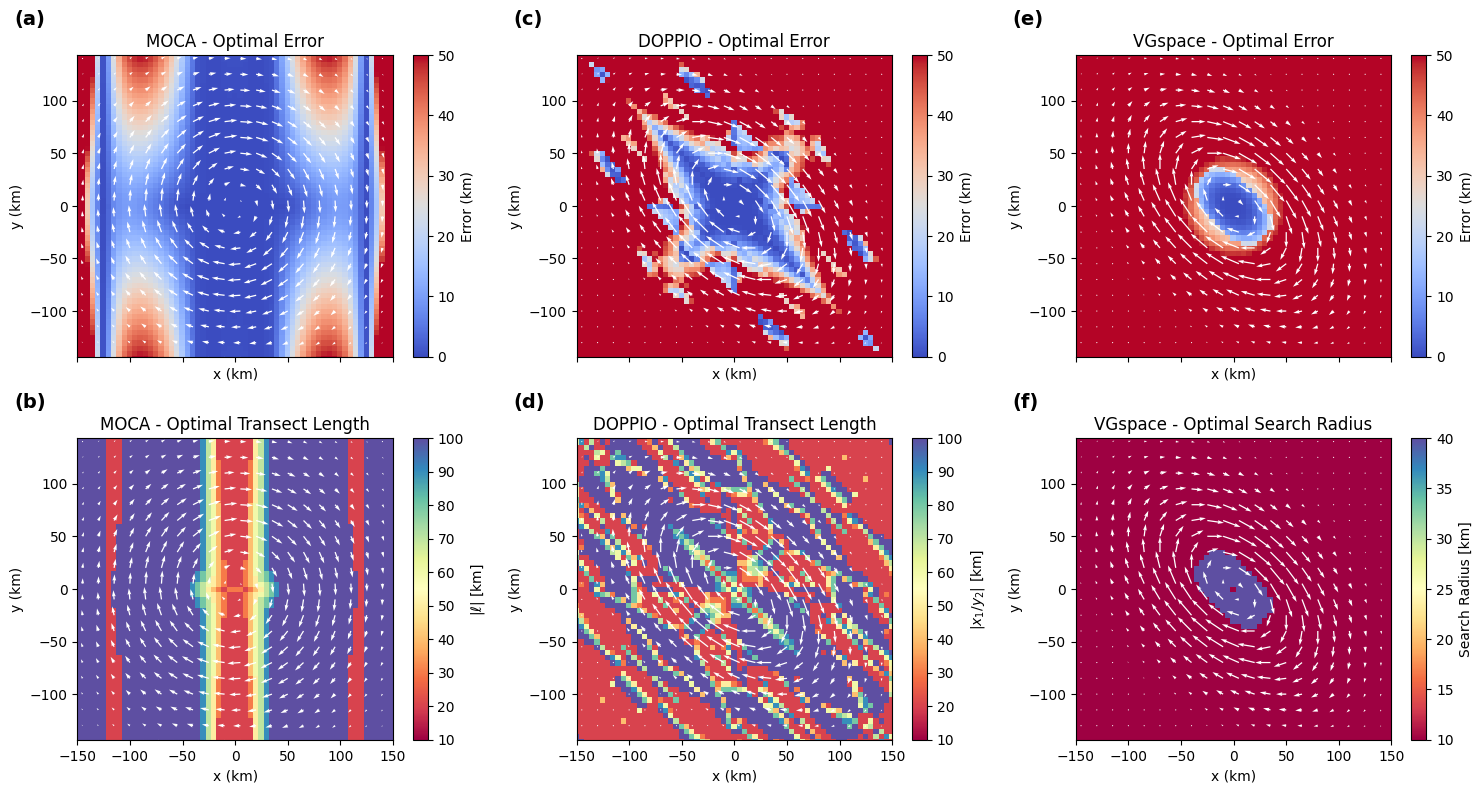

In [4]:
# Create a 2x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True)

error_mats = [E_MOCA, E_DOPPIO, E_VGspace]
r_mats     = [2 * R_MOCA * dx, 2 * R_DOPPIO * dx, R_VGspace * dx]
titles_E   = ['MOCA - Optimal Error', 'DOPPIO - Optimal Error', 'VGspace - Optimal Error']
titles_R   = ['MOCA - Optimal Transect Length', 'DOPPIO - Optimal Transect Length', 'VGspace - Optimal Search Radius']

labels = [r'$|\ell|$ [km]', r'$|x_1/y_2|$ [km]', 'Search Radius [km]']

# Parameters for the pcolor and quiver plots
vmin, vmax = 0, 50
spacing = 3  # spacing for quiver
width = .004
scale = 50
alpha = 1

tags = ['(a)', '(c)', '(e)', '(b)', '(d)', '(f)']

# Plot E matrices on the top row
for i, ax in enumerate(axs[0]):
    im = ax.pcolor(X, Y, error_mats[i].T, vmin=vmin, vmax=vmax, cmap='coolwarm')
    # if 'VG' in titles_E[i]:
    fig.colorbar(im, ax=ax, label='Error (km)')
    if 'MOCA' in titles_E[i]:
        ax.quiver(x[::spacing], y[::spacing],
              u_ICE[::spacing, ::spacing].T, v_ICE[::spacing, ::spacing].T,
              alpha=alpha, scale=scale, width=width, color='w')
    else:
        ax.quiver(x[::spacing], y[::spacing],
              u_IEE[::spacing, ::spacing].T, v_IEE[::spacing, ::spacing].T,
              alpha=alpha, scale=scale, width=width, color='w')
    ax.set_title(titles_E[i])
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

    ax.text(-0.2, 1.15, tags[i], transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Plot R matrices on the bottom row
for i, ax in enumerate(axs[1]):
    im = ax.pcolor(X, Y, r_mats[i].T, vmin=2*dx, vmax=None, cmap='Spectral')
    # if 'VG' in titles_E[i]:
    fig.colorbar(im, ax=ax, label=labels[i])
    if 'MOCA' in titles_E[i]:
        ax.quiver(x[::spacing], y[::spacing],
              u_ICE[::spacing, ::spacing].T, v_ICE[::spacing, ::spacing].T,
              alpha=alpha, scale=scale, width=width, color='w')
    else:
        ax.quiver(x[::spacing], y[::spacing],
              u_IEE[::spacing, ::spacing].T, v_IEE[::spacing, ::spacing].T,
              alpha=alpha, scale=scale, width=width, color='w')
    ax.set_title(titles_R[i])
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

    ax.text(-0.2, 1.15, tags[i+3], transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

for ax in axs.flat:

    ax.axis('equal')
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)

plt.tight_layout()
plt.show()

In [5]:
# def get_quadrant(i, j, center):
#     if i >= center[0] and j > center[1]:
#         return 1  # Top-right
#     elif i < center[0] and j >= center[1]:
#         return 2  # Top-left
#     elif i <= center[0] and j < center[1]:
#         return 3  # Bottom-left
#     else:
#         return 4  # Bottom-right

def get_quadrant(i, j, center):
    q1 = (i >= center[0]) & (j > center[1])
    q2 = (i < center[0]) & (j >= center[1])
    q3 = (i <= center[0]) & (j < center[1])
    q4 = ~(q1 | q2 | q3)  # Everything else (Bottom-right)

    return np.select([q1, q2, q3, q4], [1, 2, 3, 4])

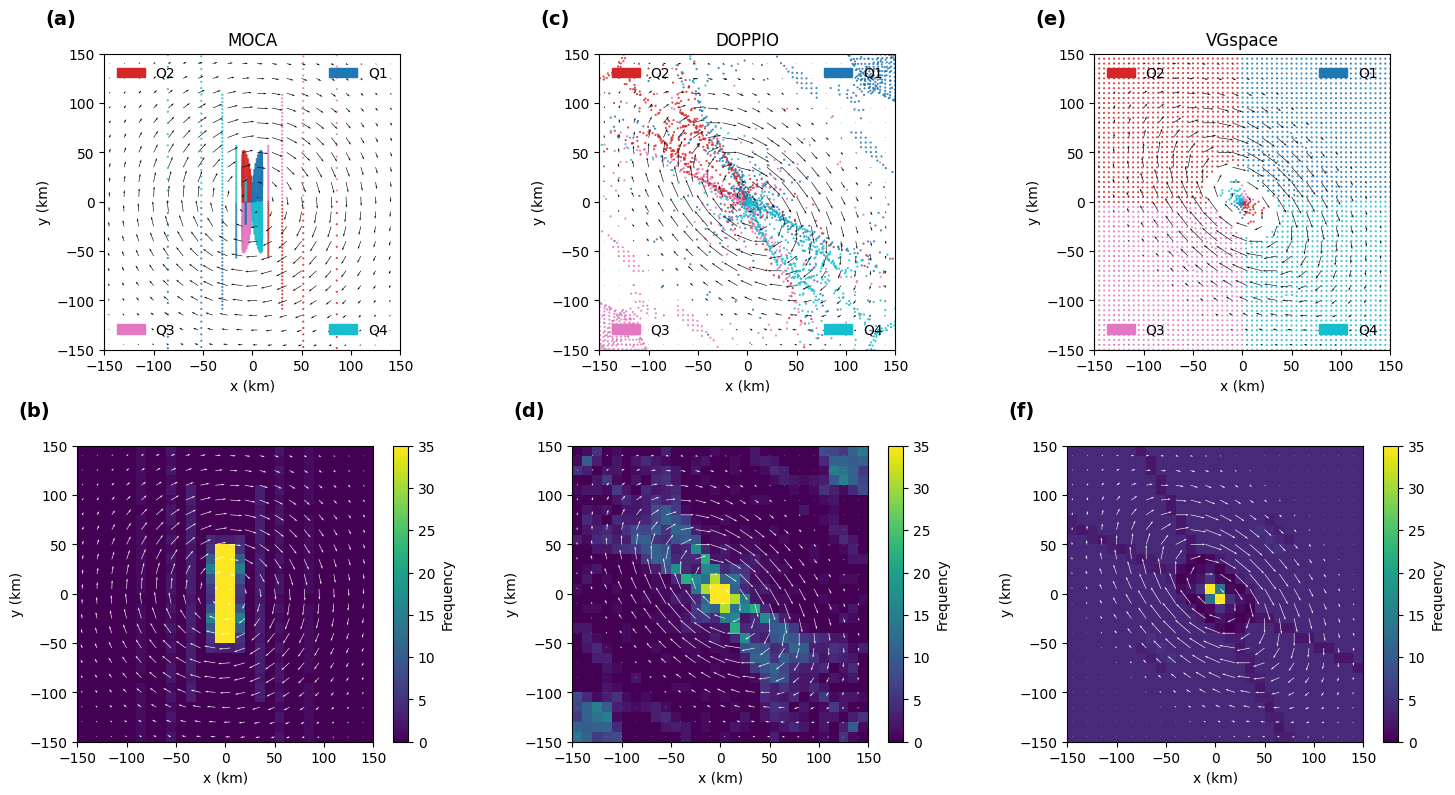

In [21]:
import matplotlib.patches as mpatches

dfs = [MOCA_df, DOPPIO_df, VGspace_df]
titles = ['MOCA', 'DOPPIO', 'VGspace']
spacing, width = 3, 0.002
grid_size = 10
x_bins = np.arange(-150, 151, grid_size)
y_bins = np.arange(-150, 151, grid_size)

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
tags = ['(a)', '(c)', '(e)', '(b)', '(d)', '(f)']

# Top row: scatter + quiver
for i, ax in enumerate(axs[0]):
    df = dfs[i]
    x0, y0 = df['x0'].to_numpy(), df['y0'].to_numpy()
    nic, njc = df['i'].astype(int).to_numpy(), df['j'].astype(int).to_numpy()

    quad = get_quadrant(nic, njc, center=(len(x)//2, len(y)//2))
    legend_locs = {1: 'upper right', 2: 'upper left', 3: 'lower left', 4: 'lower right'}
    scatter = ax.scatter(x0, y0, marker='.', s=1, c=quad, cmap='tab10')
    unique_quads = np.append(np.unique(quad), 0)

    for q in unique_quads:
        if q == 0:
            handles_q = [mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')]
            legend = ax.legend(handles=handles_q, loc=legend_locs[1], frameon=False)
            legend.set_visible(False) # False legend to fix bug
        else:
            handles_q = [mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')]
            legend = ax.legend(handles=handles_q, loc=legend_locs[q], frameon=False)
            ax.add_artist(legend)  
    
    U, V = (u_ICE, v_ICE) if titles[i] == 'MOCA' else (u_IEE, v_IEE)
    ax.quiver(x[::spacing], y[::spacing], U[::spacing, ::spacing].T, V[::spacing, ::spacing].T,
              alpha=1, scale=50, width=width, color='k')
    ax.set_aspect('equal')
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_title(titles[i])

    ax.text(-0.2, 1.15, tags[i], transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Bottom row: heatmap + quiver
heatmaps = []
for i, ax in enumerate(axs[1]):
    df = dfs[i]
    x0, y0 = df['x0'].to_numpy(), df['y0'].to_numpy()
    H, xedges, yedges = np.histogram2d(x0, y0, bins=[x_bins, y_bins])
    im = ax.pcolormesh(xedges, yedges, H.T, cmap='viridis', shading='auto', vmin=0, vmax=35)
    heatmaps.append(im)
    
    U, V = (u_ICE, v_ICE) if titles[i] == 'MOCA' else (u_IEE, v_IEE)
    ax.quiver(x[::spacing], y[::spacing], U[::spacing, ::spacing].T, V[::spacing, ::spacing].T,
              alpha=1, scale=50, width=width, color='w')

    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    ax.set_aspect('equal')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    
    fig.colorbar(im, ax=ax, label='Frequency')

    ax.text(-0.2, 1.15, tags[i+3], transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()
